# Experiments on Graph-Generative-Models
#### Overview

The baseline models are tested on several datasets and measured under 4 metrics (*degree, clustering, orbit, spectral*).

The generic graph datasets are:
- Grid: 100 graphs are generated with $100\leq |V| \leq 400$;
- Community-small: 100 graphs are generated with $12\leq |V| \leq 20$;
- Grid: 100 graphs are generated with $100\leq |V| \leq 400$;
- Caveman: 200 graphs are generated with $5\leq |V| \leq 10$;
- Cora: 200 graphs are generated with $9\leq |V| \leq 87$;
- Breast: 100 graphs are generated with $12\leq |V| \leq 18$;
- Ego-small: 200 graphs are generated with $4\leq |V| \leq 18$;
- ~~Protein: 918 graphs are generated with $100\leq |V| \leq 500$;~~
- ~~3D Point-Cloud (FirstMM-DB): 41 graphs are generated with $\bar{|V|} > 1000$~~

Following the experimental setting as in ["GraphRNN: Generating Realistic Graphs with Deep Auto-regressive Models"](https://arxiv.org/abs/1802.08773), we conduct a 80\%-20\% split of the graph samples in each dataset. Then we generate the same size of graph samples as the test dataset and harness the maximum mean discrepancy (MMD) to evaluate the generative graph distribution.


#### Issues with NetworkX Versions

The latest versions of NetworkX (2.x) is not completely compatible with the the 1.x versions. Some of the datasets provided are generated with the 1.x versions. However, since the GraphAF and GraphDF are implemented with the 2.x versions, the datasets need to be converted to the 2.x versions. The conversion is done in the following part.

### Clear Cache

In [1]:
%pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()                           


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% |  1% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |


### Changing Current Directory

In [1]:
import os
path = "./GDSS_o/"
os.chdir(path)

### Assign Dataset and Seed

In [2]:
datasets = ['grid', 'DD', 'community_small', 'ego_small', 'caveman', 'FIRSTMM_DB']
dataset = datasets[3]
seed = 42

### Generating Dataset

In [4]:
!python data/data_generators.py --dataset $dataset

Loading graph dataset: FIRSTMM_DB
56468
126038
Graphs loaded, total num: 24
FIRSTMM_DB 24
995


### Load and Calculate the Metrics for All Generated Data

In [1]:
import os
path = "./GDSS/"
os.chdir(path)

datasets = ['community', 'caveman', 'breast', 'cora', 'ego']
dataset = datasets[4]

model_name = 'DF'

seeds = [11, 12, 13, 14, 15]

metric_selection = 'EMD'

from sampler import Sampler, Sampler_mol
from evaluation.stats import eval_graph_list
from evaluation.mmd import gaussian, gaussian_emd
from utils.logger import Logger, set_log, start_log, train_log, sample_log, check_log
from data.data_generators import load_dataset
import networkx as nx
import numpy as np
import pickle
from scipy import sparse
import math

def save_graph_list(G_list, fname):
    with open(fname, "wb") as f:
        pickle.dump(G_list, f)

def get_graph(adj):
    '''
    get a graph from zero-padded adj
    :param adj:
    :return:
    '''
    # remove all zeros rows and columns
    adj = adj[~np.all(adj == 0, axis=1)]
    adj = adj[:, ~np.all(adj == 0, axis=0)]
    adj = np.asmatrix(adj)
    G = nx.from_numpy_matrix(adj)
    return G

def pick_connected_component_new(G):
    adj_list = G.adjacency()
    for id,adj in enumerate(adj_list):
        id_min = min(adj)
        if id<id_min and id>=1:
        # if id<id_min and id>=4:
            break
    node_list = list(range(id)) # only include node prior than node "id"
    G = G.subgraph(node_list)
    G = max(nx.connected_component_subgraphs(G), key=len)
    return G

def adjs_to_graphs(adjs, is_cuda=False):
    graph_list = []
    for adj in adjs:
        if is_cuda:
            adj = adj.detach().cpu().numpy()
        G = nx.from_numpy_matrix(adj)
        G.remove_edges_from(nx.selfloop_edges(G))
        G.remove_nodes_from(list(nx.isolates(G)))
        if G.number_of_nodes() < 1:
            G.add_node(1)
        graph_list.append(G)
    return graph_list


four_metrics = []

for seed in seeds:
    gen_dir = '../' + dataset + '_test_'+ model_name +'/' + dataset + '_' + model_name + '_adj'+ str(seed) +'.pkl'
    dataset_dir = '../' + dataset + '_test_'+ model_name +'/' + dataset + '_dataset_adjs.pkl'
    gen_save_dir = '../' + dataset + '_test_' + model_name + '/' + dataset + '_' + model_name + '_graph.pkl'
    dataset_save_dir = '../' + dataset + '_test_' + model_name + '/' + dataset + '_dataset.pkl'

    with open(gen_dir, 'rb') as f:
        gen_adj_list = pickle.load(f)

    with open(dataset_dir, "rb") as f:
        dataset_list = pickle.load(f)

    adjs_gen = [a[0,0,:,:] for a in gen_adj_list]
    adjs_dataset = [g.toarray() for g in dataset_list]

    gen_list = adjs_to_graphs(adjs_gen)
    graph_list = adjs_to_graphs(adjs_dataset)

    save_graph_list(gen_list, gen_save_dir)
    save_graph_list(graph_list, dataset_save_dir)

    gen_save_dir = '../' + dataset + '_test_'+ model_name + '/' + dataset + '_'+ model_name + '_graph.pkl'
    dataset_save_dir = '../' + dataset + '_test_' + model_name + '/' + dataset + '_dataset.pkl'

    with open(gen_save_dir, 'rb') as f:
        gen_graph_list = pickle.load(f)

    with open(dataset_save_dir, "rb") as f:
        graph_list = pickle.load(f)

    test_split = 0.2

    print('Target dataset:' + dataset)
    if dataset == 'cora':
        print('for cora, only take first 200 samples')
        graph_list = graph_list[:200].copy()
    test_size = int(test_split * len(graph_list))
    train_size = len(graph_list) - test_size
    train_graph_list, test_graph_list = graph_list[:train_size], graph_list[train_size:]
    # train_graph_list, test_graph_list = graph_list[test_size:], graph_list[:test_size]
    print('Length of testing dataset:' + str(len(test_graph_list)))
    print('Length of gen dataset:' + str(len(gen_graph_list)))
    methods = ['degree', 'cluster', 'orbit', 'spectral'] 
    kernels = {}
    if metric_selection == 'EMD':
        kernels = {'degree':gaussian_emd, 
                    'cluster':gaussian_emd, 
                    'orbit':gaussian,
                    'spectral':gaussian_emd}
        result_dict = eval_graph_list(test_graph_list, gen_graph_list, methods, kernels)
    else:
        result_dict = eval_graph_list(test_graph_list, gen_graph_list)
    four_metrics.append(list(result_dict.values()))
print(np.mean(np.array(four_metrics), axis=0))
print(np.std(np.array(four_metrics), axis=0))

Target dataset:caveman
Length of testing dataset:40
Length of gen dataset:40
degree    : 0.084139
cluster   : 0.362693
orbit     : 0.045216
spectral  : 0.060471
Target dataset:caveman
Length of testing dataset:40
Length of gen dataset:40
degree    : 0.107527
cluster   : 0.289818
orbit     : 0.017332
spectral  : 0.059011
Target dataset:caveman
Length of testing dataset:40
Length of gen dataset:40
degree    : 0.084408
cluster   : 0.380712
orbit     : 0.075698
spectral  : 0.060988
Target dataset:caveman
Length of testing dataset:40
Length of gen dataset:40
degree    : 0.040202
cluster   : 0.357890
orbit     : 0.042257
spectral  : 0.059299
Target dataset:caveman
Length of testing dataset:40
Length of gen dataset:40
degree    : 0.066305
cluster   : 0.475227
orbit     : 0.074467
spectral  : 0.060993
[0.07651611 0.37326786 0.05099407 0.06015232]
[0.02238318 0.0596043  0.02192782 0.00084137]


### Plotting Graphs and Edge Distribution

0 Graph with 16 nodes and 35 edges
1 Graph with 16 nodes and 34 edges
2 Graph with 16 nodes and 71 edges
3 Graph with 16 nodes and 34 edges
4 Graph with 16 nodes and 42 edges
5 Graph with 16 nodes and 28 edges
6 Graph with 16 nodes and 39 edges
7 Graph with 16 nodes and 40 edges
8 Graph with 16 nodes and 39 edges
9 Graph with 16 nodes and 63 edges
10 Graph with 16 nodes and 36 edges
11 Graph with 16 nodes and 37 edges
12 Graph with 16 nodes and 43 edges
13 Graph with 16 nodes and 39 edges
14 Graph with 15 nodes and 42 edges
15 Graph with 16 nodes and 47 edges
16 Graph with 16 nodes and 43 edges
17 Graph with 16 nodes and 36 edges
18 Graph with 16 nodes and 35 edges
19 Graph with 16 nodes and 41 edges
20 Graph with 16 nodes and 26 edges
21 Graph with 16 nodes and 46 edges
22 Graph with 16 nodes and 37 edges
23 Graph with 16 nodes and 51 edges
24 Graph with 16 nodes and 57 edges
25 Graph with 16 nodes and 42 edges
26 Graph with 16 nodes and 31 edges
27 Graph with 16 nodes and 43 edges
28

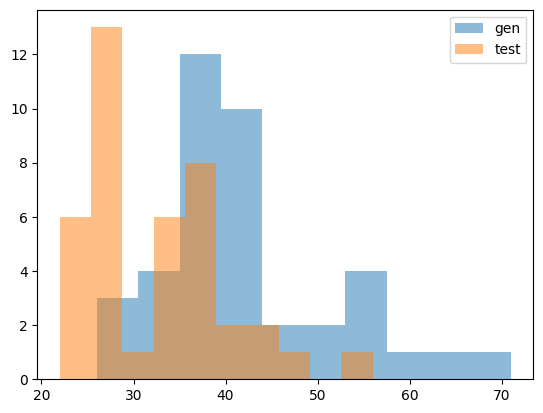

In [2]:
from utils.plot import plot_graphs_list
import numpy as np
from matplotlib import pyplot

tar_graph = test_graph_list
tar_graph = gen_graph_list

for idx, g in enumerate(tar_graph):
    print(idx, g)

plot_graphs_list(graphs=tar_graph, title=dataset, max_num=16, save_dir=dataset)

gen_edges = [g.number_of_edges() for g in gen_graph_list]
test_edges = [g.number_of_edges() for g in test_graph_list]
print(gen_edges)
print(test_edges)
pyplot.hist(gen_edges, alpha=0.5, label='gen')
pyplot.hist(test_edges,  alpha=0.5, label='test')
pyplot.legend(loc='upper right')
pyplot.show()

### Plotting and Analyzing Max Degree for Generated Datasets

1000
[34.2]
34.2


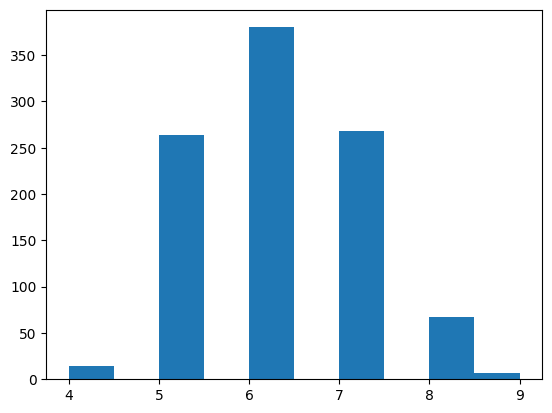

In [2]:
import pickle
import networkx as nx
import os
import numpy as np
import matplotlib.pyplot as plt


caveman_filenames = ['caveman_5000-sample20:05:40']
max_degree = 6
percentage_per_seed = []
for caveman_file in caveman_filenames:
    save_dir = './samples/pkl/caveman/test/' + caveman_file + '.pkl'
    max_degree_list = []
    with open(save_dir, 'rb') as f:
        graph_list = pickle.load(f)
    print(len(graph_list))
    for g in graph_list:
        max_degree_list.append(max([deg[1] for deg in g.degree()]))
    count = sum(deg > max_degree for deg in max_degree_list)
    percentage_per_seed.append(count / len(max_degree_list)*100)
print(percentage_per_seed)
print(np.mean(percentage_per_seed))
plt.hist(max_degree_list)
plt.show()

### Preprocess Graph Datasets in NetworkX 1.x (Fix Format Issue in GraphAF / GraphDF)
Try aternatively with NetworkX 1.x and 2.x to convert between these two

#### Load Dataset and Extract Adjacency 

In [1]:
import pickle
import networkx as nx

datasets = ['enzymes']
model_names = ['AF', 'DF']
for mod in model_names:
    for d in datasets:
        with open(d + '_test_' + mod +'/' + d + '.pkl', "rb") as f:
            graph_list = pickle.load(f)
        adjs_dataset = [nx.adjacency_matrix(g) for g in graph_list]
        with open(d + '_test_' + mod + '/' + d + '_dataset_adjs.pkl', 'wb') as handle:
            pickle.dump(adjs_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

Now Change the Jupyter Kernel to the one with the other NetworkX version.

#### Converting to Graph List in the Other NetworkX Version

In [1]:
import networkx as nx
import numpy as np
import pickle
from scipy import sparse

datasets = ['breast', 'caveman', 'cora']
datasets = ['enzymes']
model_names = ['AF', 'DF']
def save_graph_list(G_list, fname):
    with open(fname, "wb") as f:
        pickle.dump(G_list, f)
for mod in model_names:
    for d in datasets:
        dataset_dir = d + '_test_'+ mod + '/' + d + '_dataset_adjs.pkl'
        save_dir = d + '_test_' + mod + '/' + d + '.pkl'
        with open(dataset_dir, "rb") as f:
            a_list = pickle.load(f)
        graph_list = [nx.from_numpy_matrix(a.toarray()) for a in a_list]

        save_graph_list(graph_list, save_dir)

## DiGress

In [ ]:
import torch
import numpy as np
import networkx as nx
path = "DiGress/outputs/2022-12-26/21-51-01/generated_graphs.npz"
with np.load(path) as data:
    print(data.files)
    adjs = data['arr_1']
print(adjs)
# g = nx.from_numpy_matrix(adjs)
nx.draw(adjs, with_labels=True)

In [7]:
path = "DiGress/data/community_12_21_100.pt"
adjs, _, _, _, _, _, _, _  = torch.load(path)
print(adjs[1])
path = "DiGress/data/breast.pt"
adjs  = torch.load(path)
print(adjs[2])

tensor([[0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.],
        [0., 0.,

### Conversion

In [44]:
import pickle
paths = {"breast": "breast_test_AF/breast_dataset_adjs.pkl",
        "caveman": "caveman_test_AF/caveman_dataset_adjs.pkl",
        "cora": "cora_test_AF/cora_dataset_adjs.pkl",
        "enzymes": "enzymes_test_AF/enzymes_dataset_adjs.pkl",
        "community": "community_test_AF/community_dataset_adjs.pkl",
        "ego": "ego_test_AF/ego_dataset_adjs.pkl"}

for name, path in paths.items():
    print(name)
    with open(path, "rb") as f:
        alist = pickle.load(f)
    if name == "cora":
        alist = alist[:200]
    new_dataset = []
    for a in alist:
        new_dataset.append(torch.from_numpy(a.toarray()))
    print(len(new_dataset))
    torch.save(new_dataset, "datasets_digress/" + name + ".pt")



breast
100
caveman
200
cora
200
enzymes
587
community
100
ego
200


### Metrics

In [ ]:
import torch
import numpy as np
import networkx as nx

PREFIX_PATH = "digress_results/"
SUFFIX_PATH = "_exp_adjacency_matrices.npy"
full_path = PREFIX_PATH + "breast" + SUFFIX_PATH

data = np.load(full_path, allow_pickle=True)
print(data)



In [1]:
path = "./GDSS_o/"
os.chdir(path)

In [2]:
import os
import torch
import numpy as np
import networkx as nx



datasets = ['community', 'caveman', 'breast', 'cora', 'ego', 'enzymes']

PREFIX_PATH = "../digress_results/"
SUFFIX_PATH = "_exp_adjacency_matrices.npy"

model_name = "AF"

metric_selection = 'EMD'

from sampler import Sampler, Sampler_mol
from evaluation.stats import eval_graph_list
from evaluation.mmd import gaussian, gaussian_emd
from utils.logger import Logger, set_log, start_log, train_log, sample_log, check_log
from data.data_generators import load_dataset
import networkx as nx
import numpy as np
import pickle
from scipy import sparse
import math

def save_graph_list(G_list, fname):
    with open(fname, "wb") as f:
        pickle.dump(G_list, f)

def get_graph(adj):
    '''
    get a graph from zero-padded adj
    :param adj:
    :return:
    '''
    # remove all zeros rows and columns
    adj = adj[~np.all(adj == 0, axis=1)]
    adj = adj[:, ~np.all(adj == 0, axis=0)]
    adj = np.asmatrix(adj)
    G = nx.from_numpy_matrix(adj)
    return G

def pick_connected_component_new(G):
    adj_list = G.adjacency()
    for id,adj in enumerate(adj_list):
        id_min = min(adj)
        if id<id_min and id>=1:
        # if id<id_min and id>=4:
            break
    node_list = list(range(id)) # only include node prior than node "id"
    G = G.subgraph(node_list)
    G = max(nx.connected_component_subgraphs(G), key=len)
    return G

def adjs_to_graphs(adjs, is_cuda=False):
    graph_list = []
    for adj in adjs:
        if is_cuda:
            adj = adj.detach().cpu().numpy()
        G = nx.from_numpy_matrix(adj)
        G.remove_edges_from(nx.selfloop_edges(G))
        G.remove_nodes_from(list(nx.isolates(G)))
        if G.number_of_nodes() < 1:
            G.add_node(1)
        graph_list.append(G)
    return graph_list


for dataset in datasets:

    four_metrics = []


    gen_dir = PREFIX_PATH + dataset + SUFFIX_PATH
    dataset_dir = '../' + dataset + '_test_'+ model_name +'/' + dataset + '_dataset_adjs.pkl'
    gen_save_dir = PREFIX_PATH + dataset + '_graph.pkl'
    dataset_save_dir = '../' + dataset + '_test_' + model_name + '/' + dataset + '_dataset.pkl'

    with open(dataset_dir, "rb") as f:
        dataset_list = pickle.load(f)

    gen_adj_list = np.load(gen_dir, allow_pickle=True)


    # adjs_gen = [a[0,0,:,:] for a in gen_adj_list]
    adjs_gen = [a for a in gen_adj_list]
    adjs_dataset = [g.toarray() for g in dataset_list]

    gen_list = adjs_to_graphs(adjs_gen)
    graph_list = adjs_to_graphs(adjs_dataset)

    save_graph_list(gen_list, gen_save_dir)
    save_graph_list(graph_list, dataset_save_dir)

    with open(gen_save_dir, 'rb') as f:
        gen_graph_list = pickle.load(f)

    with open(dataset_save_dir, "rb") as f:
        graph_list = pickle.load(f)

    test_split = 0.2

    print('Target dataset:' + dataset)
    if dataset == 'cora':
        print('for cora, only take first 200 samples')
        graph_list = graph_list[:200].copy()
    test_size = int(test_split * len(graph_list))
    train_size = len(graph_list) - test_size
    train_graph_list, test_graph_list = graph_list[:train_size], graph_list[train_size:]
    # train_graph_list, test_graph_list = graph_list[test_size:], graph_list[:test_size]
    print('Length of testing dataset:' + str(len(test_graph_list)))
    print('Length of gen dataset:' + str(len(gen_graph_list)))
    methods = ['degree', 'cluster', 'orbit'] 
    
    single_len = len(gen_graph_list) / 5
    for i in range(5):
        print("------------------")
        gen_graph_sublist = gen_graph_list[int(i*single_len):int((i+1)*single_len)]

        kernels = {}
        if metric_selection == 'EMD':
            kernels = {'degree':gaussian_emd, 
                        'cluster':gaussian_emd, 
                        'orbit':gaussian}
            result_dict = eval_graph_list(test_graph_list, gen_graph_sublist, methods, kernels)
        else:
            result_dict = eval_graph_list(test_graph_list, gen_graph_sublist)
        four_metrics.append(list(result_dict.values()))
    print(np.mean(np.array(four_metrics), axis=0))
    print(np.std(np.array(four_metrics), axis=0))

Target dataset:community
Length of testing dataset:20
Length of gen dataset:100
------------------
degree    : 0.109162
cluster   : 0.091073
orbit     : 0.042991
------------------
degree    : 0.027908
cluster   : 0.031928
orbit     : 0.013363
------------------
degree    : 0.030758
cluster   : 0.029276
orbit     : 0.035769
------------------
degree    : 0.058389
cluster   : 0.034385
orbit     : 0.032720
------------------
degree    : 0.008783
cluster   : 0.017320
orbit     : 0.004528
[0.047     0.0407964 0.0258742]
[0.03487885 0.02581221 0.01449101]
Target dataset:caveman
Length of testing dataset:40
Length of gen dataset:200
------------------
degree    : 0.006413
cluster   : 0.053094
orbit     : 0.002368
------------------
degree    : 0.030804
cluster   : 0.035901
orbit     : 0.002167
------------------
degree    : 0.013159
cluster   : 0.054460
orbit     : 0.002905
------------------
degree    : 0.029405
cluster   : 0.026479
orbit     : 0.006319
------------------
degree    : 0.0145

In [5]:
sample_time = {"breast": 457.76,
                "caveman": 51.568,
                "cora": 698.584,
                "enzymes": 1647.376,
                "community": 28.624,
                "ego": 43.825}
for dataset in datasets:
    print(dataset,sample_time[dataset]/5)


community 5.7248
caveman 10.3136
breast 91.55199999999999
cora 139.71679999999998
ego 8.765
enzymes 329.4752
